# ディープニューラルネットワークの実装

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

## まず適当なテストデータを作る
1dCNNは多くの場合で時系列解析に用いられます。そのため、テストデータは簡単な異常検知モデルにしてみましょう。

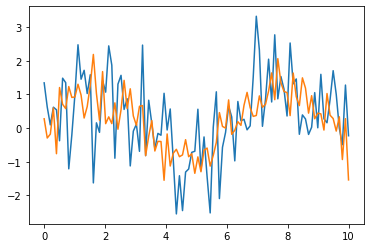

In [22]:
data_length = 100
n_sample = 100000
anomaly_noise = np.random.randn(n_data)    #異常値は分散が大きい
nomaly_noise  = np.random.randn(n_data)/2  #正常値は分散が小さい

#時系列とラベルを生成
t = np.linspace(0,10,n_data)
x_anomaly = np.array([np.sin(t) + anomaly_noise for i in range(n_sample//2)])
x_nomaly  = np.array([np.sin(t) + nomaly_noise  for i in range(n_sample//2)])
X = np.concatenate([x_anomaly,x_nomaly])
y = np.concatenate([np.ones(n_sample//2),np.zeros(n_sample//2)])

#シャッフル
rand_idx = np.arange(n_sample)
np.random.shuffle(rand_idx)
X = X[rand_idx,:]
y = y[rand_idx]

#描画
plt.plot(t,x_anomaly[0,:])
plt.plot(t,x_nomaly[0,:])
plt.show()

ここでは二値分類となっていますが、OneHotEncodingすれば、問題なく実行されるはずなので、二値ですがOneHotEncodingしましょう。

もちろん二値分類用に別に出力層を作っても問題ありません。余力があればぜひやってみてください。

## 訓練データとテストデータに分ける

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y)

## 実装に向けて必要そうなクラスや関数リストをまとめておく

**最低限必要なLayer Class**
- 畳み込み層(Conv1d)
- 平滑化層(Flatten)
- 全結合出力層(Affin)
 - 回帰
 - 二値分類
 - 多値分類
- Pooling層

あればうれしい
- Global Average Pooling層
- Atrous層(Dilated層)

### Optimizerのクラス群
- SGD
- Adagrad

発展的なOptimizer
- Adam
- Eve
- 最近提案されたやつ(Adaboundsとか？)

## 実装していきましょう

## 活性化関数の実装（ここからまだ）

活性化関数は畳み込み層や全結合層のforward/backward両方で使われるため、それより先に作る必要があります。


In [ ]:
class ReLu:
    def forward(self,X):
        pass
    
    def backward(self)
        pass

In [ ]:
class Sigmoid:
    def forward(self,X):
        pass
    
    def backward(self)
        pass

In [ ]:
class Tanh:
    def forward(self,X):
        pass
    
    def backward(self)
        pass

## Conv1D Layer

Conv1dのインスタンスを生成する際にインスタンス変数にそのレイヤーが持つべきパラメータを与えておく。
まず間違いなく必要なのがフィルターなので、それに値するw,bをインスタンス変数に持たせておけばよい。
他にもストライド、パディングも必要になるが、まずはなかったことにして、後で考える。

うまく設計すれば入力の形状や出力の形状も必要なくなるが、引数の受け渡しが煩雑になりそうなので、今回は自分で計算して引数に渡す。

いきなりクラスを作るとバグを作りそうなので、上述のものは後でインスタンス変数に変えられるということを念頭に置きながらまずはそれぞれの関数を作る。

### Forward Propagation と Back Propagationを実装

In [6]:
#w,b等は__init__()メソッドで初期化するのでインスタンス変数が保有している（と考える）
#パディングの大きさ、ストライドの広さも持っている（と考える）
def forward(X):
    """
    X(入力)      :( batch_size, ch_in, data_size )
    W(フィルタ)  :( ch_out, filter_size )
    b(バイアス)　:( ch_out )
    S(ストライド):( 1 )#int <= 2Dだとまた違う
    P(パディング):( 1 )#int <= 2Dだとまた違う

    Y(出力)      :( batch_size, ch_size, (data_size + 2*P - filter_size) // S + 1 )
    """
    
    
    
    return Y

In [ ]:
#forwardでの出力Yを持っておかないと計算できないので、クラスで設計するときはインスタンス変数に渡して、backward()メソッドでも使えるようにしておく
def backward(Y,dY):
    """
    dY(後ろからの入力) :( batch_size, ch_size, (data_size + 2*P - filter_size) // S + 1 )
    W(フィルタ)        :( ch_out, filter_size )
    b(バイアス)　      :( ch_out )
    S(ストライド)      :( 1 )#int
    P(パディング)      :( 1 )#int

    dX(前の層への出力) :( batch_size, ch_in, data_size )
    """
    
    
    
    return dX

In [ ]:
class Cinv1d_full_scratch():
    def __init__(self):
        pass
    
    def forward(self):
        pass
    
    def forward(self):
        pass

理想的に抽象度高く実装する場合


レイヤーはクラスで設計して、それぞれforward/backwardメソッドを持たせておくことで、アーキテクチャ全体を設計するクラス（別に作る）で統一的に呼び出せるようにする。
レイヤーが呼び出された時点で初期値を設定したいので、レイヤークラスの__init__()メソッドで初期化する。

**optimizerとの関係**  
optimizeは層の設定時に決定したいので、引数にoptimizerのクラスオブジェクトをそのまま渡す。
この辺りは細かい設計の問題だと思うが、optimizer内でパラメータを最適化していくため、optimizerでそれぞれのパラメータを初期化するのがいいと思う。ただし、入力の形状を使ってパラメータを初期化するはずなので、optimizerをクラスのインスタンス生成後（中）にパラメータを生成しないといけない。具体的には
```
Conv1D(in_shape=(1,100),out_shape=(2, 98),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad())
```

こんな風に書けるといいと思う